---
# 
---

In this notebook

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error

2025-04-02 22:43:40.477978: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 22:43:40.545367: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 22:43:40.614409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743648220.675585  989524 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743648220.693090  989524 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743648220.816839  989524 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Define files

In [2]:
data_dir = '../data/'

ghg = 'GreenHouse_Gases/processed/'

climate_file = 'ECCC/processed/daily/daily_processed.csv'
#climate_file = 'ECCC/processed/monthly/monthly_processed.csv'

population_file = 'Population/processed/Montreal.csv'

co2_file = 'ch4_1850-2099_SSP2_45.csv'
ch4_file = 'co2_1850-2099_SSP2_45.csv'


### Define variables

**Daily**

In [3]:
Tmax = 'Max Temp (°C)'
Tmin =  'Min Temp (°C)' 
Tmean = 'Mean Temp (°C)'

cols = ['Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag',
       'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)',
       'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag',
       'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)',
       'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag',
       'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag']

**Monthly**

### Read data files

In [4]:
co2_df = pd.read_csv(os.path.join(data_dir, ghg, co2_file), index_col=0, parse_dates=True)
co2_df

,CH4
Year,
1850-01-01,791.600000
1851-01-01,792.859068
1852-01-01,794.156502
1853-01-01,795.493289
1854-01-01,796.859405
...,...
2095-01-01,1698.879883
2096-01-01,1695.429810
2097-01-01,1692.139893


In [5]:
ch4_df = pd.read_csv(os.path.join(data_dir, ghg, ch4_file), index_col=0, parse_dates=True)
ch4_df.drop(columns = 'Data Source', inplace=True)
ch4_df

,CO2
Year,
1850-01-01,285.200000
1851-01-01,285.100000
1852-01-01,285.000000
1853-01-01,285.000000
1854-01-01,284.900000
...,...
2095-01-01,600.885986
2096-01-01,601.365967
2097-01-01,601.796997


In [6]:
pop_df = pd.read_csv(os.path.join(data_dir, population_file), index_col=0, parse_dates=True)
pop_df

,Population
1801-01-01,9.000000e+03
1802-01-01,9.389547e+03
1803-01-01,9.788026e+03
1804-01-01,1.019544e+04
1805-01-01,1.061293e+04
...,...
2095-01-01,2.258385e+06
2096-01-01,2.249969e+06
2097-01-01,2.240726e+06
2098-01-01,2.230707e+06


In [7]:
wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)
wx_df

/tmp/ipykernel_989524/1851272773.py:1: DtypeWarning: Columns (5,11,13,15,17,19,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,0.0,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,NaN,NaN,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,NaN,NaN,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,NaN,NaN,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN


In [8]:
stn = wx_df['Station'].unique()[0]
stn

'Montreal (McTavish/McGill)'

### Plot the data

/tmp/ipykernel_989524/1294534305.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


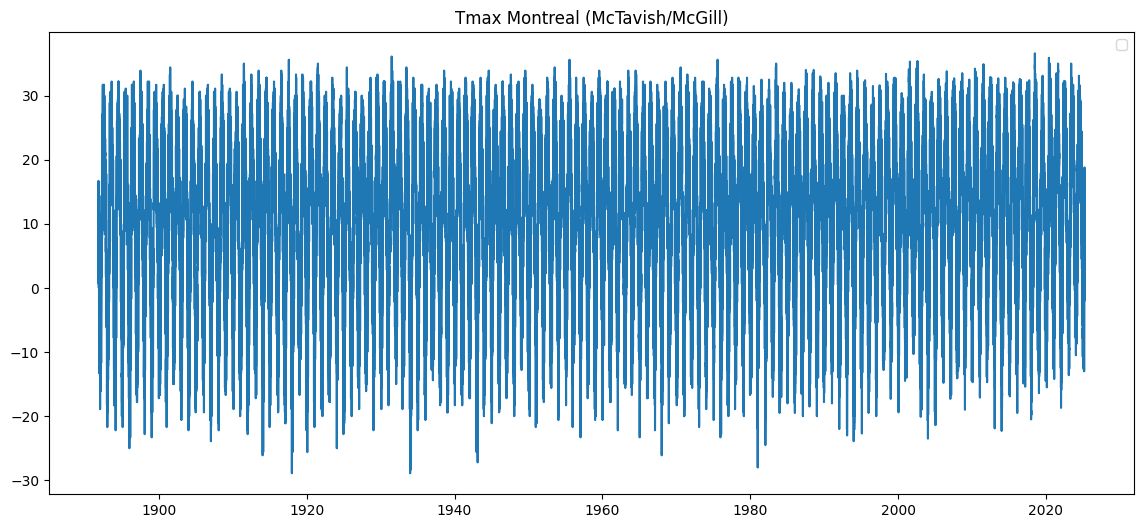

In [9]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmax])

plt.title(f'Tmax {stn}')

plt.legend()

plt.show()

/tmp/ipykernel_989524/4162194945.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


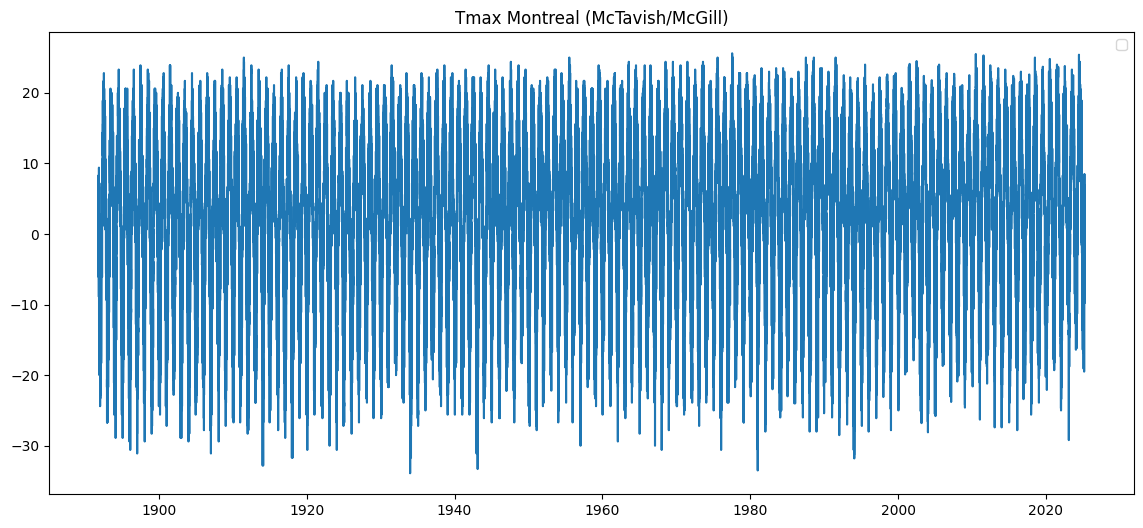

In [10]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmin])

plt.title(f'Tmin {stn}')

plt.legend()

plt.show()

/tmp/ipykernel_989524/3143457143.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


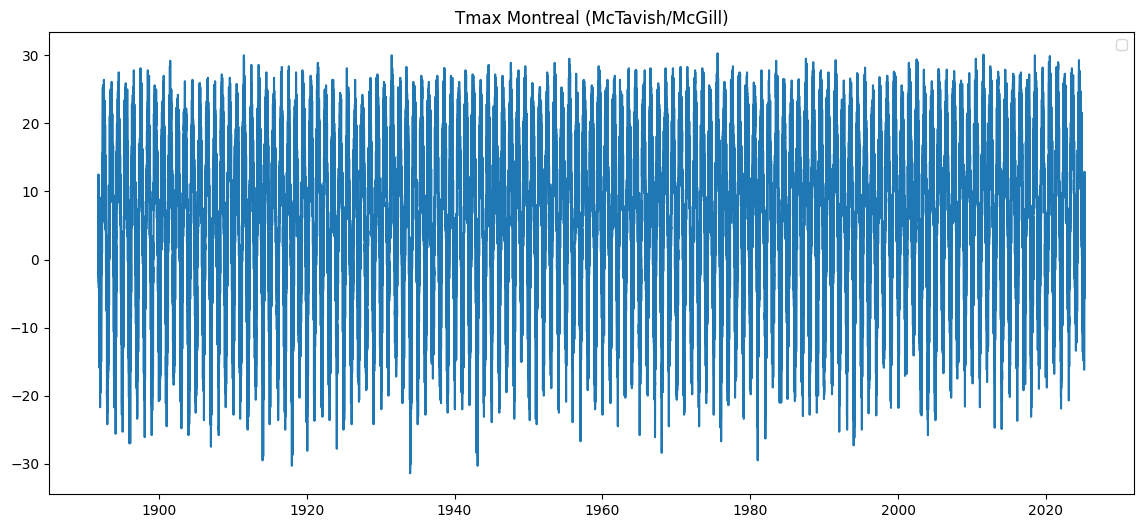

In [11]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmean])

plt.title(f'Tmean {stn}')

plt.legend()

plt.show()

In [15]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
Year,,,,,,,,,,,,,,,,,,,,,
1891,71,71,71,71,71,71,71,0,71,0,...,71,8,71,10,0,0,0,0,0,0
2025,86,86,86,86,86,86,86,0,86,0,...,0,0,85,1,86,0,27,0,27,0
